In [ ]:
%load_ext autoreload
%autoreload 2

import datajoint as dj
dj.config["enable_python_native_blobs"] = True
dj.config["database.host"] = '134.2.168.16'
dj.config['schema_name'] = "nnfabrik_monkey_mei"
schema = dj.schema("nnfabrik_monkey_mei")

import os
from os import listdir
from os.path import isfile, join

import torch
import numpy as np
import pickle 
import time
import matplotlib.pyplot as plt
import seaborn as sns
import time

import nnfabrik
from nnfabrik import main, builder
from nnfabrik.main import *

import nnvision
from nnvision.tables.from_nnfabrik import TrainedModel
from nnvision.tables.from_nnfabrik import DataInfo

import insilico_stimuli
from insilico_stimuli.stimuli import *
from insilico_stimuli.parameters import *

In [3]:
# nnfabrik main
from nnvision.tables.main import MonkeyExperiment
from nnvision.tables.from_mei import TrainedEnsembleModel, MEIMethod
from featurevis.main import MEITemplate
from nnvision.tables.measures import OracleScore

@schema
class MEI_update(MEITemplate):
    trained_model_table = TrainedEnsembleModel
    selector_table = MonkeyExperiment.Units

In [4]:
# loading model
ensemble_hash = 'e7a8d0b961ee37ffda0779bfed95f1cf'
dataset_hash = 'a737408da40cfedd036c2eb1b8a31ff1'

model_key = (TrainedModel * TrainedEnsembleModel.Member() & dict(ensemble_hash=ensemble_hash)).fetch("KEY", limit=1, order_by="score DESC")
model = TrainedModel().load_model(model_key, include_dataloader=False)
model.eval()

# model specifics for optimization
data_key = '3631807112901'
unit_idx = 27
unit_id = 26

# number of model neurons 
n_units = model.readout[data_key].outdims

# image dimensions
w, h = 41, 41

data_key: {data_key}, unit_id = {unit_id}, image shape: {mei.shape}


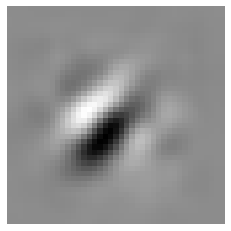

In [5]:
# MEI of our example Neuron
mei_path = (MEI_update & dict(dataset_hash=dataset_hash, unit_id=unit_id, data_key=data_key)).fetch1("mei")
mei = torch.load(mei_path, map_location='cpu').numpy().squeeze()
#mei = torch.load(mei_path).numpy().squeeze()
plt.imshow(mei, cmap="gray")
plt.axis("off");
print("data_key: {data_key}, unit_id = {unit_id}, image shape: {mei.shape}")

# Instantiation of gabor class (2 mio parameter combinations)

In [ ]:
# Finite Set
canvas_size         = [w, h]
sizes               = FiniteParameter([float(val) for val in range(5, 31)][::5])
spatial_frequencies = FiniteParameter([float(val) for val in np.linspace(1/80, 2/5, 10)])
contrasts           = FiniteParameter([float(val) for val in np.linspace(0.0, 1.0, 5)])
orientations        = FiniteParameter([float(val) for val in np.linspace(0.0, np.pi, 10)])
phases              = FiniteParameter([float(val) for val in np.linspace(0.0, 2*np.pi, 10)]) 
grey_levels         = FiniteParameter([0.0])
eccentricities      = FiniteParameter([float(val) for val in np.linspace(0.0, 0.99, 5)])
locations           = FiniteParameter([[float(x), float(y)] for x in range(12, 28) 
                                                            for y in range(12, 28)][::16])

gabor_set = GaborSet(canvas_size=canvas_size,
                     locations=locations,
                     sizes=sizes,
                     spatial_frequencies=spatial_frequencies,
                     contrasts=contrasts,
                     orientations=orientations, 
                     phases=phases, 
                     grey_levels=grey_levels,
                     eccentricities=eccentricities)

# Find optimal Stimuli with Bayesian search method (finite grid-search)

In [ ]:
start_time = time.time()

best_params_list = []
values_list = []

for unit in range(0, n_units):
    best_params, values = gabor_set.find_optimal_stimulus(model, data_key, unit)
    best_params_list.append(best_params)
    values_list.append(values)

print("--- %s seconds ---" % (time.time() - start_time))

Text(0.5, 1.0, 'Best Gabor (Bayes), unit_idx:6')

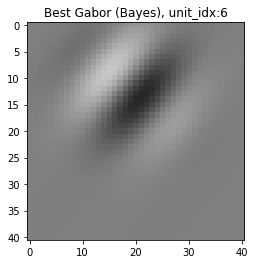

In [49]:
# rename optimal parameter list from Gabor search (if commented out, we will use pre-pasted results from other optimization, see below)
#params_optGab_all = best_params_list

# plot
unit_idx = 6
img_bayes = gabor_set.get_image_from_params(best_params_list[unit_idx])
plt.imshow(img_bayes, cmap='gray', vmin=-1, vmax=1)
plt.title('Best Gabor (Bayes), unit_idx:{}'.format(unit_idx))

# Find optimal stimulus with bruteforce search method

In [ ]:
start_time = time.time()

best_params_BF, _ , max_act_BF = gabor_set.find_optimal_stimulus_bruteforce(model=model, 
                                                                            data_key=data_key, 
                                                                            batch_size=100, 
                                                                            return_activations=True)

print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
unit_idx = 27
img_bayes = gabor_set.stimulus(**best_params_BF[unit_idx])
plt.imshow(img_bayes, cmap='gray', vmin=-1, vmax=1)
plt.title('Best Gabor (BF), unit_idx:{}'.format(unit_idx))

In [51]:
# results from some older optimization runs. Skip this cell, if you ran the above optimizations over the 2mio
# parameters above. Otherwise, use the pasted optimal values from previous experiments (below) for further analysis.

# Bayes
params_optGab_all = [{'location_width': 28.999999999125983, 'location_height': 29.0, 'size': 15.691862776176395, 'spatial_frequency': 0.018089348479954137, 'contrast': 0.5000000000347056, 'orientation': 2.387971119230705, 'phase': 0.889487022223217, 'gamma': 0.7722092300429875, 'grey_level': -0.0007389826580563859}, {'location_width': 18.697212678802224, 'location_height': 20.008063635401353, 'size': 29.999999999999996, 'spatial_frequency': 0.13333333333333333, 'contrast': 0.846188032800978, 'orientation': 0.9295818388184545, 'phase': 5.409559741767102, 'gamma': 0.4473662340329577, 'grey_level': -0.0007058730104099396}, {'location_width': 19.095013251459285, 'location_height': 21.681430464575467, 'size': 30.0, 'spatial_frequency': 0.06075188491198329, 'contrast': 1.0, 'orientation': 1.8571575026288045, 'phase': 1.9074914190545453, 'gamma': 0.8255549002770823, 'grey_level': -1.4112437076363102e-05}, {'location_width': 16.480628918538976, 'location_height': 16.263932800693745, 'size': 29.999999999999904, 'spatial_frequency': 0.08883620582944204, 'contrast': 0.9999999999999997, 'orientation': 2.447089810604233, 'phase': 5.111627225436957, 'gamma': 0.7352890664480711, 'grey_level': 0.0005945867153640779}, {'location_width': 14.674585651243335, 'location_height': 20.35778191902005, 'size': 19.82462716126617, 'spatial_frequency': 0.032677778728874146, 'contrast': 0.9372472783267263, 'orientation': 2.5265998246020787, 'phase': 1.4142876455175155, 'gamma': 0.6151514308386736, 'grey_level': -0.0006753362892132172}, {'location_width': 22.13531946022162, 'location_height': 21.896053948576593, 'size': 29.999999999989587, 'spatial_frequency': 0.06259990633363435, 'contrast': 0.8773187704677148, 'orientation': 1.5021924460140352, 'phase': 2.4155178997751636, 'gamma': 0.4714536402355788, 'grey_level': -0.00018773952628139826}, {'location_width': 14.342665355196623, 'location_height': 22.594566571345496, 'size': 26.685907469044647, 'spatial_frequency': 0.07222276608961307, 'contrast': 0.9682693979339354, 'orientation': 1.2910639525554182, 'phase': 1.7544045324186144, 'gamma': 0.8430856657203252, 'grey_level': 0.0008558502932745453}, {'location_width': 14.866842170894031, 'location_height': 21.63549772624244, 'size': 19.09984897652805, 'spatial_frequency': 0.054702767850599146, 'contrast': 0.8926862683819619, 'orientation': 0.872734847409013, 'phase': 0.0, 'gamma': 0.3719218715937346, 'grey_level': 0.0009660360914053034}, {'location_width': 15.567966133441548, 'location_height': 12.942969170915433, 'size': 29.9999999999772, 'spatial_frequency': 0.06683278483187556, 'contrast': 0.9999999999996584, 'orientation': 1.9845224312370944, 'phase': 3.0923422041135207, 'gamma': 0.9473790068057681, 'grey_level': -0.00021842338642169535}, {'location_width': 18.39761459182597, 'location_height': 20.40360340245873, 'size': 27.140723783920585, 'spatial_frequency': 0.10079345934945008, 'contrast': 0.9420740205155804, 'orientation': 1.8872267406080658, 'phase': 9.952460178903512e-15, 'gamma': 0.7112364827675075, 'grey_level': 0.00016357444324562975}, {'location_width': 18.599927084337725, 'location_height': 21.630688116594825, 'size': 19.050829984704453, 'spatial_frequency': 0.09626499295018938, 'contrast': 0.6511947733821173, 'orientation': 2.429829123628514, 'phase': 6.283185307179582, 'gamma': 0.6266719893681034, 'grey_level': 0.0008486803104105656}, {'location_width': 17.51376618620869, 'location_height': 23.76552846867514, 'size': 29.571033286455815, 'spatial_frequency': 0.09134517060491, 'contrast': 0.9978601434527179, 'orientation': 1.9789041655978816, 'phase': 4.799717572749057, 'gamma': 0.7420254549148066, 'grey_level': -0.0002530649390191323}, {'location_width': 20.117702836586083, 'location_height': 18.525188239394254, 'size': 28.83404063693395, 'spatial_frequency': 0.05600730840794538, 'contrast': 0.7671124178634996, 'orientation': 3.061810925207713, 'phase': 3.0100933102990908, 'gamma': 0.8534091022615284, 'grey_level': -0.00035077603517442275}, {'location_width': 14.610942027151406, 'location_height': 22.317865302345073, 'size': 27.262626540299188, 'spatial_frequency': 0.0688583598202779, 'contrast': 0.674189362023634, 'orientation': 2.0141401662815754, 'phase': 2.7551331751131283, 'gamma': 0.9036464857261237, 'grey_level': -0.00035915057707090324}, {'location_width': 17.815915692654215, 'location_height': 29.0, 'size': 29.595039261019473, 'spatial_frequency': 0.050469414230979434, 'contrast': 0.9806610259950009, 'orientation': 1.6812264160833204, 'phase': 0.05980021342949162, 'gamma': 0.44697815777562844, 'grey_level': 0.0009319949770004441}, {'location_width': 20.107775497337812, 'location_height': 21.587840303888292, 'size': 29.999999999999986, 'spatial_frequency': 0.05495264036334732, 'contrast': 0.7193412337815035, 'orientation': 3.1415926535897922, 'phase': 1.1976835980106655, 'gamma': 0.5186697466664201, 'grey_level': -7.116713244517897e-05}, {'location_width': 19.30250100270286, 'location_height': 22.595082513439607, 'size': 22.284493939238917, 'spatial_frequency': 0.045999280268883, 'contrast': 1.0, 'orientation': 0.8072830363107986, 'phase': 3.104660581050028, 'gamma': 0.8434713420301918, 'grey_level': 0.000974916706768024}, {'location_width': 14.756956832200267, 'location_height': 15.662896010626394, 'size': 29.999999999999027, 'spatial_frequency': 0.02313567529542322, 'contrast': 0.9865359871090554, 'orientation': 6.124428646456488e-14, 'phase': 3.606095813958256, 'gamma': 0.41246998262179696, 'grey_level': 9.37393524945776e-05}, {'location_width': 17.9989132643913, 'location_height': 18.410853981005538, 'size': 24.35359577740511, 'spatial_frequency': 0.08534386099216999, 'contrast': 0.974149270133003, 'orientation': 1.9519644139947898, 'phase': 4.727603309985269, 'gamma': 0.6666358570838969, 'grey_level': -0.00045859552951197074}, {'location_width': 16.155277413334144, 'location_height': 22.181885374907225, 'size': 28.374694923953697, 'spatial_frequency': 0.031882369869227205, 'contrast': 1.0, 'orientation': 2.460184942537775, 'phase': 2.959668860362238, 'gamma': 0.7003695412156337, 'grey_level': 0.0009755259789895579}, {'location_width': 17.461833579356178, 'location_height': 20.398830132402203, 'size': 23.565534417905482, 'spatial_frequency': 0.0737441396758929, 'contrast': 0.8442445678633852, 'orientation': 2.0583744668894584, 'phase': 4.184541902875355, 'gamma': 0.48541155507001965, 'grey_level': -0.001}, {'location_width': 17.125434897382966, 'location_height': 22.557922644521078, 'size': 26.042392492945282, 'spatial_frequency': 0.050815283437202735, 'contrast': 0.857974421360006, 'orientation': 1.5958685947555353, 'phase': 4.5566685471350254, 'gamma': 0.7550278033853648, 'grey_level': -0.00019689194606631723}, {'location_width': 17.836483153753946, 'location_height': 19.117175983875665, 'size': 27.139886839176057, 'spatial_frequency': 0.08421524630056737, 'contrast': 0.8755556805409455, 'orientation': 2.548690822647156, 'phase': 6.283185307179586, 'gamma': 0.6678475290397654, 'grey_level': 0.0009342869342243521}, {'location_width': 15.606657441225908, 'location_height': 23.606348903868156, 'size': 27.393159956273593, 'spatial_frequency': 0.08515749831916625, 'contrast': 0.8471367469509541, 'orientation': 2.120589869819995, 'phase': 3.102729607235059, 'gamma': 0.6113098269301838, 'grey_level': -0.000450879639346726}, {'location_width': 19.103915845036973, 'location_height': 25.722335340304056, 'size': 29.999999999999996, 'spatial_frequency': 0.08815904219525798, 'contrast': 0.9572198282210886, 'orientation': 2.206028772509736, 'phase': 4.325574869271388, 'gamma': 0.8761968272998004, 'grey_level': 0.0004116032466071715}, {'location_width': 17.976916417954406, 'location_height': 19.591146146616182, 'size': 25.72876602748427, 'spatial_frequency': 0.06610155536721735, 'contrast': 0.6805612498580264, 'orientation': 1.9760733994812667, 'phase': 5.236482890091366, 'gamma': 0.3350153136948126, 'grey_level': 0.000762651154949581}, {'location_width': 15.215111026808813, 'location_height': 18.058547007756456, 'size': 19.45600981403793, 'spatial_frequency': 0.07563608649711384, 'contrast': 0.8819528094519054, 'orientation': 2.426635873232719, 'phase': 2.9124144605760582, 'gamma': 0.3, 'grey_level': -8.1548353654884e-05}, {'location_width': 19.89333923466984, 'location_height': 17.94600700143532, 'size': 29.99999999988011, 'spatial_frequency': 0.07759534439309561, 'contrast': 0.9999999999981481, 'orientation': 1.9947134681402625, 'phase': 1.0808625051062155, 'gamma': 0.8665578074005984, 'grey_level': 0.0006968446242826051}, {'location_width': 21.418060960451562, 'location_height': 22.396163784966177, 'size': 30.0, 'spatial_frequency': 0.08086294298656063, 'contrast': 0.8022226590494601, 'orientation': 2.088584234023777, 'phase': 4.324963226104729, 'gamma': 0.5107422755682944, 'grey_level': -0.00042442678982922675}]
act_values = [({'activation': 1.483094912723716}, {'activation': {'activation': 2.4239853051941034e-09}}), ({'activation': 6.958334049317244}, {'activation': {'activation': 2.879872648601975e-07}}), ({'activation': 9.428738711387208}, {'activation': {'activation': 2.8565695599697826e-07}}), ({'activation': 3.0186774971386625}, {'activation': {'activation': 2.470763896536363e-08}}), ({'activation': 0.615466321386531}, {'activation': {'activation': 1.3775898682836625e-09}}), ({'activation': 6.265708199273375}, {'activation': {'activation': 3.768438662746599e-07}}), ({'activation': 5.234251357433698}, {'activation': {'activation': 3.390768974601006e-08}}), ({'activation': 3.9957118704745787}, {'activation': {'activation': 8.735429634262906e-09}}), ({'activation': 2.8926238993110474}, {'activation': {'activation': 9.532931191175513e-09}}), ({'activation': 2.547617195687515}, {'activation': {'activation': 1.6029355091563763e-08}}), ({'activation': 3.2347516249049866}, {'activation': {'activation': 3.774421981370056e-08}}), ({'activation': 7.222439607311836}, {'activation': {'activation': 3.461494304772106e-07}}), ({'activation': 1.935968671082448}, {'activation': {'activation': 3.4555766922566402e-09}}), ({'activation': 3.133169031192124}, {'activation': {'activation': 2.802390678768239e-08}}), ({'activation': 3.9933606424870014}, {'activation': {'activation': 8.6736054462748e-08}}), ({'activation': 0.6953100287450349}, {'activation': {'activation': 1.2795480901061988e-09}}), ({'activation': 6.8502945653898015}, {'activation': {'activation': 2.3142830360075326e-07}}), ({'activation': 2.664514733599805}, {'activation': {'activation': 9.014412746582835e-09}}), ({'activation': 3.2510337872723882}, {'activation': {'activation': 7.773096747662589e-08}}), ({'activation': 7.150258167006696}, {'activation': {'activation': 2.51084441757344e-07}}), ({'activation': 1.298196146831947}, {'activation': {'activation': 6.337840455160699e-09}}), ({'activation': 2.3682795469661126}, {'activation': {'activation': 5.7513399190805816e-08}}), ({'activation': 2.5116422297873235}, {'activation': {'activation': 1.0152605606778272e-08}}), ({'activation': 4.897888053577341}, {'activation': {'activation': 1.8476844035739527e-07}}), ({'activation': 5.853404860099982}, {'activation': {'activation': 3.2344529698575903e-07}}), ({'activation': 1.1220923159976945}, {'activation': {'activation': 1.4296039318192548e-08}}), ({'activation': 1.2393658270600643}, {'activation': {'activation': 1.748055805409267e-08}}), ({'activation': 10.531938224768588}, {'activation': {'activation': 1.5221247394981111e-06}}), ({'activation': 2.3494218800687765}, {'activation': {'activation': 5.643670505362699e-08}})]
# access activation with: act_valus[unit_idx][0]['activation']

# Brute Force
best_params_BF = [{'location': [20, 20], 'size': 15, 'spatial_frequency': 0.13333333333333333, 'contrast': 0.7, 'orientation': 1.6755160819145563, 'phase': 3.141592653589793, 'gamma': 0.64, 'grey_level': 0.0}, {'location': [15, 20], 'size': 30, 'spatial_frequency': 0.1, 'contrast': 1.0, 'orientation': 1.0471975511965976, 'phase': 2.6179938779914944, 'gamma': 1, 'grey_level': 0.0}, {'location': [15, 20], 'size': 30, 'spatial_frequency': 0.05, 'contrast': 1.0, 'orientation': 1.6755160819145563, 'phase': 2.6179938779914944, 'gamma': 1, 'grey_level': 0.0}, {'location': [20, 20], 'size': 30, 'spatial_frequency': 0.06666666666666667, 'contrast': 1.0, 'orientation': 2.5132741228718345, 'phase': 2.0943951023931953, 'gamma': 1, 'grey_level': 0.0}, {'location': [15, 20], 'size': 30, 'spatial_frequency': 0.03333333333333333, 'contrast': 0.7, 'orientation': 2.5132741228718345, 'phase': 1.5707963267948966, 'gamma': 0.64, 'grey_level': 0.0}, {'location': [15, 20], 'size': 30, 'spatial_frequency': 0.06666666666666667, 'contrast': 1.0, 'orientation': 1.4660765716752369, 'phase': 4.71238898038469, 'gamma': 1, 'grey_level': 0.0}, {'location': [15, 20], 'size': 30, 'spatial_frequency': 0.06666666666666667, 'contrast': 1.0, 'orientation': 1.2566370614359172, 'phase': 3.141592653589793, 'gamma': 1, 'grey_level': 0.0}, {'location': [20, 25], 'size': 30, 'spatial_frequency': 0.1, 'contrast': 1.0, 'orientation': 0.6283185307179586, 'phase': 1.0471975511965976, 'gamma': 1, 'grey_level': 0.0}, {'location': [20, 25], 'size': 30, 'spatial_frequency': 0.025, 'contrast': 1.0, 'orientation': 1.6755160819145563, 'phase': 3.141592653589793, 'gamma': 1, 'grey_level': 0.0}, {'location': [20, 25], 'size': 30, 'spatial_frequency': 0.04, 'contrast': 1.0, 'orientation': 1.8849555921538759, 'phase': 2.0943951023931953, 'gamma': 1, 'grey_level': 0.0}, {'location': [15, 20], 'size': 30, 'spatial_frequency': 0.03333333333333333, 'contrast': 1.0, 'orientation': 1.6755160819145563, 'phase': 1.0471975511965976, 'gamma': 1, 'grey_level': 0.0}, {'location': [20, 20], 'size': 30, 'spatial_frequency': 0.1, 'contrast': 1.0, 'orientation': 1.8849555921538759, 'phase': 0.0, 'gamma': 1, 'grey_level': 0.0}, {'location': [20, 25], 'size': 30, 'spatial_frequency': 0.05, 'contrast': 1.0, 'orientation': 0.0, 'phase': 3.665191429188092, 'gamma': 1, 'grey_level': 0.0}, {'location': [15, 20], 'size': 30, 'spatial_frequency': 0.03333333333333333, 'contrast': 1.0, 'orientation': 1.8849555921538759, 'phase': 3.141592653589793, 'gamma': 1, 'grey_level': 0.0}, {'location': [20, 30], 'size': 30, 'spatial_frequency': 0.05, 'contrast': 1.0, 'orientation': 1.6755160819145563, 'phase': 5.759586531581287, 'gamma': 0.91, 'grey_level': 0.0}, {'location': [15, 20], 'size': 30, 'spatial_frequency': 0.025, 'contrast': 1.0, 'orientation': 0.20943951023931953, 'phase': 3.665191429188092, 'gamma': 1, 'grey_level': 0.0}, {'location': [20, 20], 'size': 30, 'spatial_frequency': 0.025, 'contrast': 1.0, 'orientation': 1.0471975511965976, 'phase': 3.141592653589793, 'gamma': 1, 'grey_level': 0.0}, {'location': [15, 20], 'size': 30, 'spatial_frequency': 0.05, 'contrast': 1.0, 'orientation': 2.3038346126325147, 'phase': 3.141592653589793, 'gamma': 1, 'grey_level': 0.0}, {'location': [20, 20], 'size': 30, 'spatial_frequency': 0.1, 'contrast': 1.0, 'orientation': 2.0943951023931953, 'phase': 3.141592653589793, 'gamma': 1, 'grey_level': 0.0}, {'location': [15, 20], 'size': 30, 'spatial_frequency': 0.05, 'contrast': 1.0, 'orientation': 2.5132741228718345, 'phase': 3.665191429188092, 'gamma': 1, 'grey_level': 0.0}, {'location': [20, 25], 'size': 30, 'spatial_frequency': 0.04, 'contrast': 1.0, 'orientation': 2.3038346126325147, 'phase': 2.6179938779914944, 'gamma': 1, 'grey_level': 0.0}, {'location': [20, 20], 'size': 30, 'spatial_frequency': 0.03333333333333333, 'contrast': 1.0, 'orientation': 1.8849555921538759, 'phase': 5.235987755982989, 'gamma': 1, 'grey_level': 0.0}, {'location': [15, 20], 'size': 30, 'spatial_frequency': 0.06666666666666667, 'contrast': 1.0, 'orientation': 2.7227136331111543, 'phase': 0.5235987755982988, 'gamma': 0.64, 'grey_level': 0.0}, {'location': [15, 20], 'size': 30, 'spatial_frequency': 0.1, 'contrast': 1.0, 'orientation': 2.0943951023931953, 'phase': 4.1887902047863905, 'gamma': 1, 'grey_level': 0.0}, {'location': [15, 20], 'size': 30, 'spatial_frequency': 0.1, 'contrast': 1.0, 'orientation': 2.5132741228718345, 'phase': 2.6179938779914944, 'gamma': 1, 'grey_level': 0.0}, {'location': [15, 20], 'size': 30, 'spatial_frequency': 0.06666666666666667, 'contrast': 1.0, 'orientation': 2.3038346126325147, 'phase': 5.759586531581287, 'gamma': 1, 'grey_level': 0.0}, {'location': [15, 20], 'size': 30, 'spatial_frequency': 0.05, 'contrast': 1.0, 'orientation': 2.5132741228718345, 'phase': 2.0943951023931953, 'gamma': 1, 'grey_level': 0.0}, {'location': [15, 20], 'size': 30, 'spatial_frequency': 0.1, 'contrast': 1.0, 'orientation': 2.0943951023931953, 'phase': 4.1887902047863905, 'gamma': 1, 'grey_level': 0.0}, {'location': [20, 25], 'size': 30, 'spatial_frequency': 0.06666666666666667, 'contrast': 1.0, 'orientation': 2.0943951023931953, 'phase': 3.665191429188092, 'gamma': 1, 'grey_level': 0.0}]
act_value_BF = [1.57321858, 7.86664534, 10.08334827, 3.36031985, 0.6445328, 8.17442322, 5.38155937,  4.98394966, 3.86970901, 3.20520926, 5.59743118, 7.29013777, 2.1984458,   3.73541141,  4.12842464,  1.08821535,  7.72256756,  3.03156328, 3.62267518, 7.56055737, 1.76882529, 3.43993044, 2.60815716, 6.00849104, 6.32681656, 3.29296494, 2.3624239, 12.22450829, 2.90907526]

# Get activation from param dict

In [40]:
 best_params_BF[unit_idx]

{'location': [15, 20],
 'size': 30,
 'spatial_frequency': 0.1,
 'contrast': 1.0,
 'orientation': 2.0943951023931953,
 'phase': 4.1887902047863905,
 'gamma': 1,
 'grey_level': 0.0}

In [41]:
ap = best_params_BF[unit_idx].copy()
ap['location_width'] = ap['location'][0]
ap['location_height'] = ap['location'][1]
del ap['location']

print(gabor_set.train_evaluate(auto_params=ap, 
                               model=model, 
                               data_key=data_key, 
                               unit_idx=unit_idx))

# this value should be the same as:
print(act_value_BF[unit_idx])

12.224507331848145
12.22450829


# Compare MEI and opt. Gabor (Bayes) for one unit

Text(0.5, 1.0, 'opt. Gabor (Bayes) - unit_idx:27')

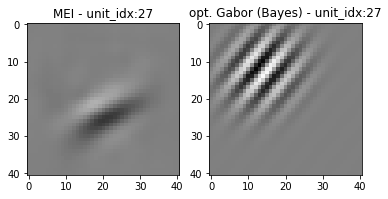

In [46]:
fig, axs = plt.subplots(1, 2)

# for single unit (unit_id = 28)
unit_idx = 27

# plot MEI
axs[0].imshow(mei, cmap="gray", vmin=-1, vmax=1)
axs[0].set_title('MEI - unit_idx:{}'.format(unit_idx))

# plot optimal Gabor (Bayes)
optGab_bayes = gabor_set.get_image_from_params(params_optGab_all[unit_idx])
axs[1].imshow(optGab_bayes, cmap="gray", vmin=-1, vmax=1)
axs[1].set_title('opt. Gabor (Bayes) - unit_idx:{}'.format(unit_idx))

# Compare MEI, Gabor (Bayes) and Gabor (BF) for all units 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warn

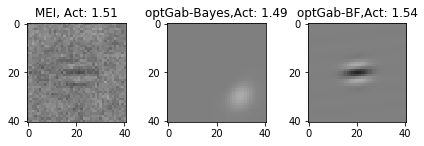

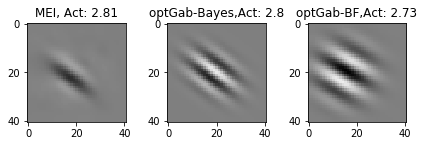

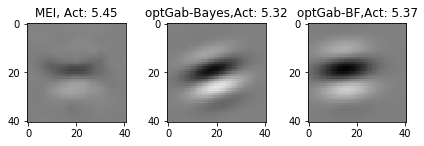

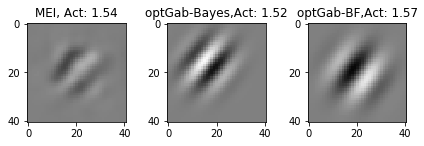

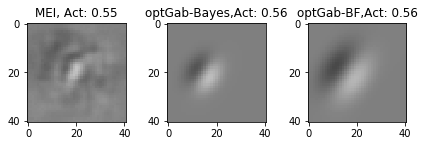

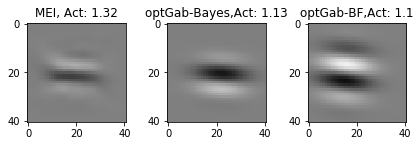

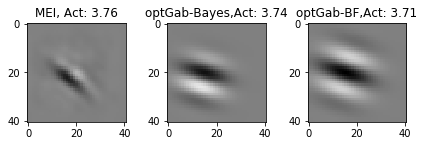

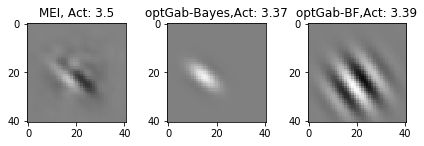

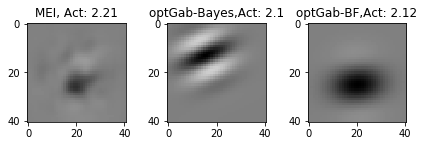

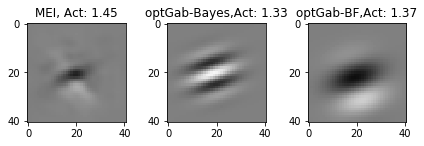

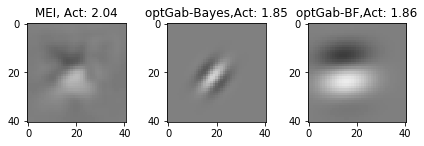

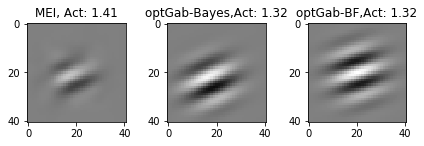

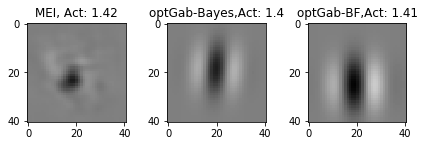

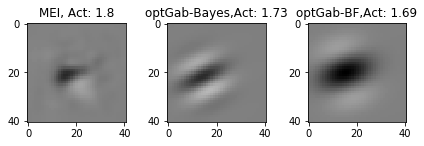

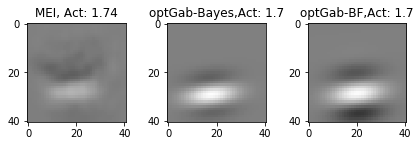

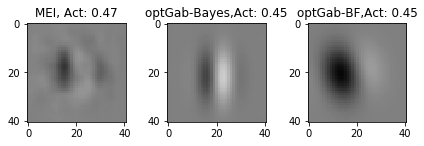

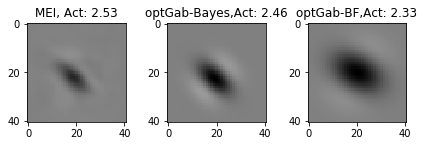

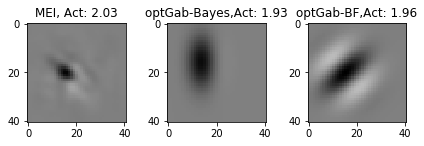

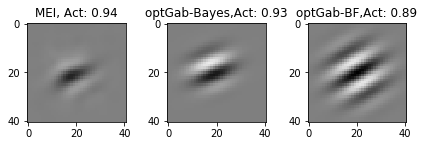

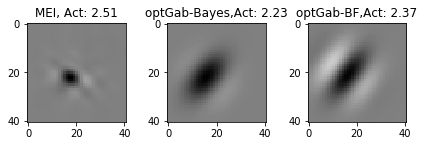

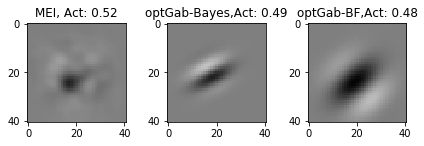

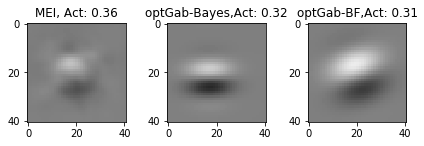

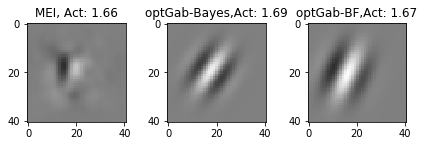

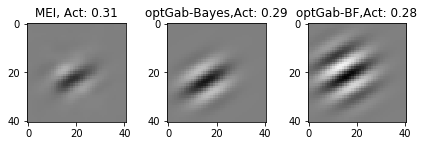

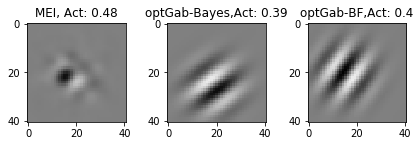

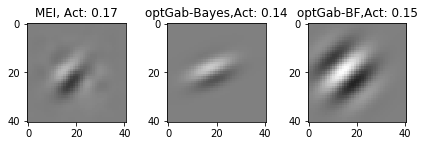

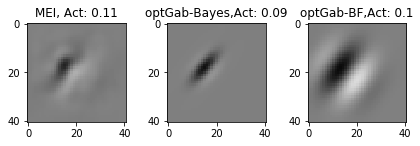

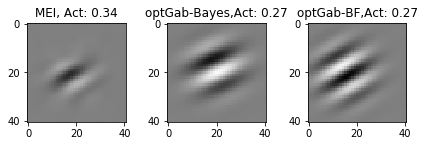

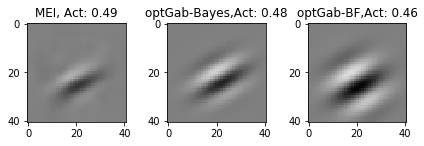

In [48]:
n_units = model.readout[data_key].outdims

index_vec = np.array(list(range(0, n_units)))
index_matrix = np.reshape(index_vec, (n_units, 1))

# init
act_mei = []
act_Bay = []
act_BF = []

for r in range(0, n_units):   
    for unit_idx in index_matrix[r,:]:
        
        if unit_idx > n_units:
            pass
        else:
            fig, axs = plt.subplots(1, 3)
            fig.tight_layout()
            
            # 1.) MEI
            mei_path = (MEI_update & dict(dataset_hash=dataset_hash, unit_id=unit_idx+1, data_key=data_key)).fetch1("mei")  # in this table, unit_id corresponds to unit_idx+1
            mei = torch.load(mei_path).cpu().numpy().squeeze()
            
            # activation on normalized image
            norm_mei = np.linalg.norm(mei)
            mei_norm = mei/norm_mei
            mei_norm_torch = mei_norm.reshape(1, 1, 41, 41) 
            mei_norm_torch = torch.tensor(mei_norm_torch).float()
            output_mei_norm = model(mei_norm_torch, data_key=data_key).detach().numpy().squeeze()
            act_mei.append(output_mei_norm)
            
            axs[0].imshow(mei, cmap="gray", vmin=-1, vmax=1)
            axs[0].set_title('MEI, Act: ' + str(round(output_mei_norm[unit_idx], 2)))

            
            # 2.) optimal Gabor (Bayes)
            optGab_bayes = gabor_set.get_image_from_params(params_optGab_all[unit_idx].copy())
        
            # activation on normalized optimal Gabor
            norm_optGab = np.linalg.norm(optGab_bayes)
            optGab_bayes_norm = optGab_bayes/norm_optGab
            optGab_bayes_norm_torch = optGab_bayes_norm.reshape(1, 1, 41, 41) 
            optGab_bayes_norm_torch = torch.tensor(optGab_bayes_norm_torch).float()
            output_optGab_bayes_norm = model(optGab_bayes_norm_torch, data_key=data_key).detach().numpy().squeeze()
            act_Bay.append(output_optGab_bayes_norm)
                
            axs[1].imshow(optGab_bayes, cmap="gray", vmin=-1, vmax=1)
            axs[1].set_title('optGab-Bayes,Act: ' + str(round(output_optGab_bayes_norm[unit_idx], 2)))

            
            # 3.) optimal Gabor (BruteForce)
            optGab_BF = gabor_set.stimulus(**best_params_BF[unit_idx])
            
            # activation on normalized optimal Gabor
            norm_optGab_BF = np.linalg.norm(optGab_BF)
            optGab_BF_norm = optGab_BF/norm_optGab_BF
            optGab_BF_norm_torch = optGab_BF_norm.reshape(1, 1, 41, 41) 
            optGab_BF_norm_torch = torch.tensor(optGab_BF_norm_torch).float()
            output_optGab_BF_norm = model(optGab_BF_norm_torch, data_key=data_key).detach().numpy().squeeze()
            act_BF.append(output_optGab_BF_norm)       
                
            axs[2].imshow(optGab_BF, cmap="gray", vmin=-1, vmax=1)
            axs[2].set_title('optGab-BF,Act: ' + str(round(output_optGab_BF_norm[unit_idx], 2)))

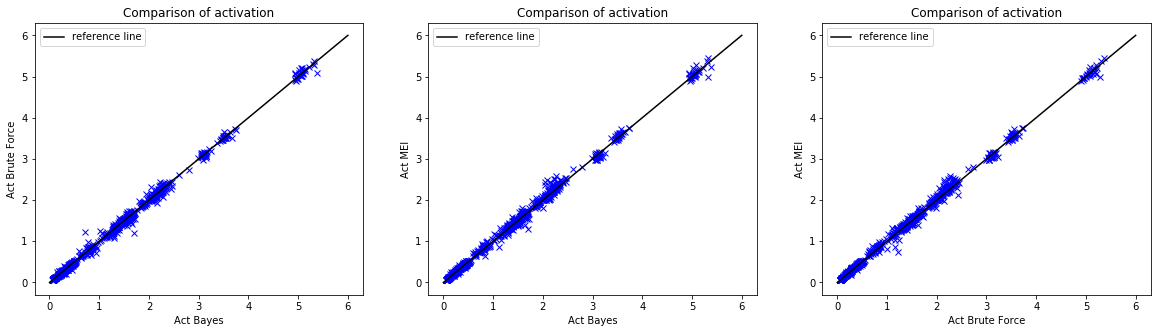

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
ax[0].plot(act_Bay, act_BF, 'x', color='b')
ax[0].plot([0,6], [0,6], color='k', label='reference line')
ax[0].set_title("Comparison of activation")
ax[0].set_xlabel("Act Bayes")
ax[0].set_ylabel("Act Brute Force")
ax[0].legend()

ax[1].plot(act_Bay, act_mei, 'x', color='b')
ax[1].plot([0,6], [0,6], color='k', label='reference line')
ax[1].set_title("Comparison of activation")
ax[1].set_xlabel("Act Bayes")
ax[1].set_ylabel("Act MEI")
ax[1].legend()

ax[2].plot(act_BF, act_mei, 'x', color='b')
ax[2].plot([0,6], [0,6], color='k', label='reference line')
ax[2].set_title("Comparison of activation")
ax[2].set_xlabel("Act Brute Force")
ax[2].set_ylabel("Act MEI")
ax[2].legend()

# normalize with MEI activation!

Since the bruteforce evaluated the activation from all stimuli, we sure expect that the optimal parameters found by the Bayesian search have a *smaller or equal* normalized activation than those found by the bruteforce method. The Bayesian method is suitable if the values are similar or identical and the optical comparison of the optimal Gabor is good enough. When this is the case, we know that the Bayesian optimizer yields good results in finite searches.


The bruteforce finding method is limited. It needs countable, finite sets to optimize over. When it comes to infinite searches, the Bayesian optimizer is favorable. Now, let us run the Bayesian optimization again for continuous parameter values and have a look again at activation and the optimal stimulus.

# Re-run Bayes optimization with continuous parameter ranges

In [52]:
# Finite Set
canvas_size         = [w, h]
sizes               = UniformRange([5.0, 35.0])
spatial_frequencies = UniformRange([1/80, 3/5])
contrasts           = UniformRange([0.0, 1.0])
orientations        = UniformRange([0.0, np.pi])
phases              = UniformRange([0.0, np.pi*2]) 
grey_levels         = FiniteParameter([0.0])
eccentricities      = UniformRange([0.0, 0.99])
locations           = UniformRange([[8.0, 33.0], [8.0, 33.0]])

gabor_set = GaborSet(canvas_size=canvas_size,
                     locations=locations,
                     sizes=sizes,
                     spatial_frequencies=spatial_frequencies,
                     contrasts=contrasts,
                     orientations=orientations, 
                     phases=phases, 
                     grey_levels=grey_levels,
                     eccentricities=eccentricities)

In [ ]:
start_time = time.time()

best_params_list = []
values_list = []

for unit in range(0, n_units):
    best_params, values = gabor_set.find_optimal_stimulus(model, data_key, unit)
    best_params_list.append(best_params)
    values_list.append(values)

print("--- %s seconds ---" % (time.time() - start_time))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warn

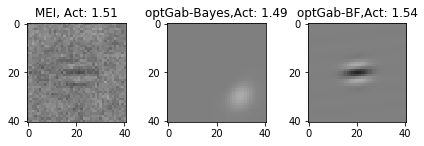

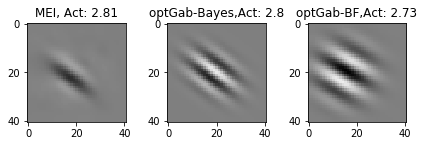

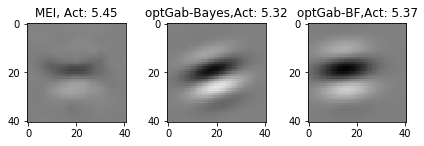

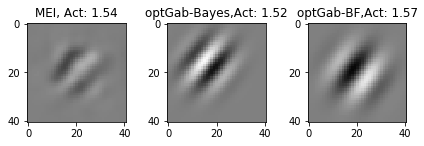

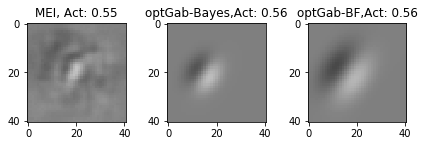

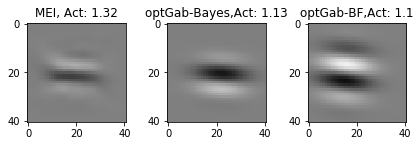

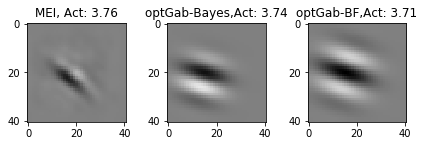

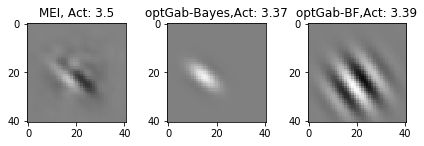

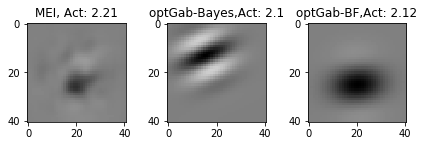

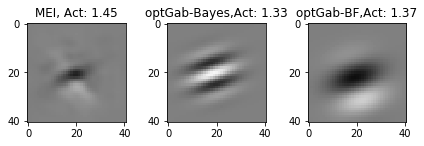

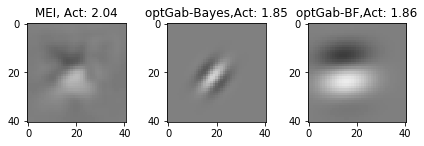

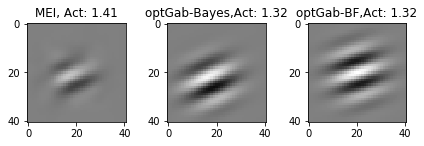

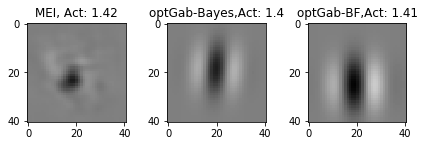

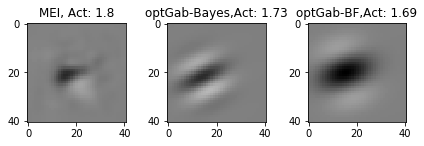

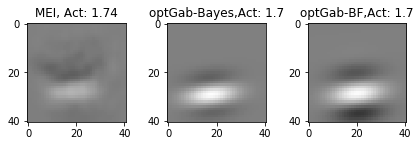

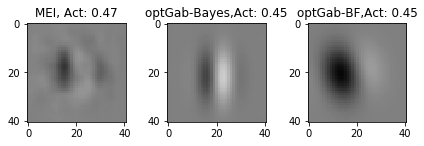

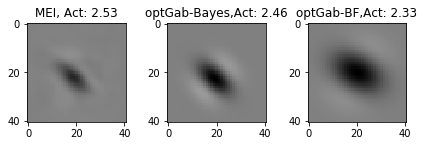

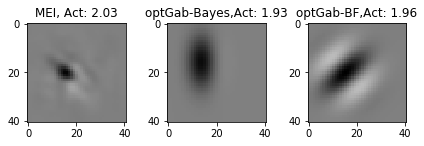

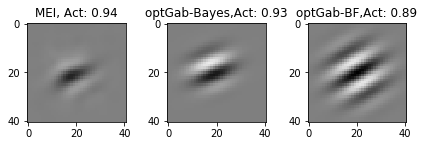

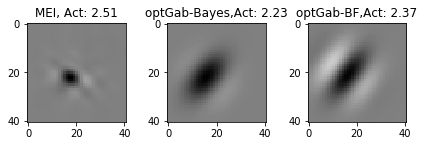

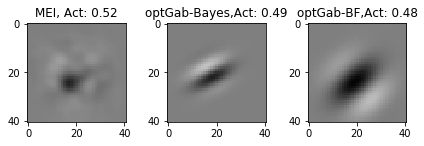

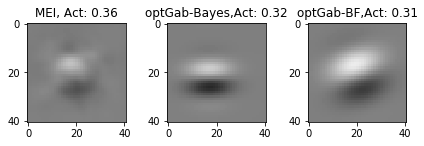

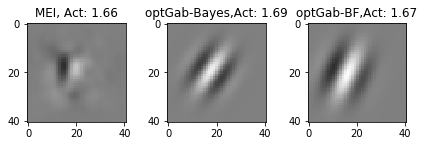

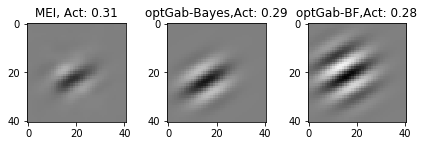

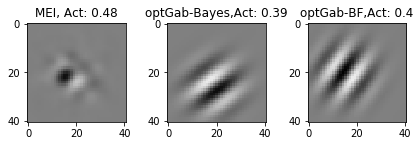

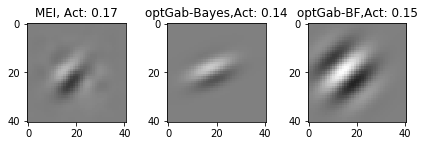

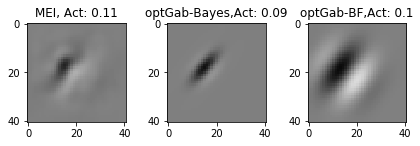

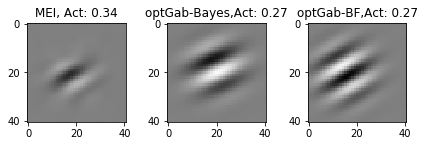

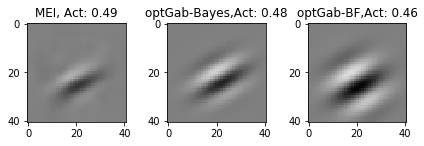

In [54]:
# now, re-run the cell from above (comparison of MEI, Bayes, BF):

# init
act_mei = []
act_Bay = []
act_BF = []

for r in range(0, n_units):   
    for unit_idx in index_matrix[r,:]:
        
        if unit_idx > n_units:
            pass
        else:
            fig, axs = plt.subplots(1, 3)
            fig.tight_layout()
            
            # 1.) MEI
            mei_path = (MEI_update & dict(dataset_hash=dataset_hash, unit_id=unit_idx+1, data_key=data_key)).fetch1("mei")  # in this table, unit_id corresponds to unit_idx+1
            mei = torch.load(mei_path).cpu().numpy().squeeze()
            
            # activation on normalized image
            norm_mei = np.linalg.norm(mei)
            mei_norm = mei/norm_mei
            mei_norm_torch = mei_norm.reshape(1, 1, 41, 41) 
            mei_norm_torch = torch.tensor(mei_norm_torch).float()
            output_mei_norm = model(mei_norm_torch, data_key=data_key).detach().numpy().squeeze()
            act_mei.append(output_mei_norm)
            
            axs[0].imshow(mei, cmap="gray", vmin=-1, vmax=1)
            axs[0].set_title('MEI, Act: ' + str(round(output_mei_norm[unit_idx], 2)))

            
            # 2.) optimal Gabor (Bayes)
            optGab_bayes = gabor_set.get_image_from_params(best_params_list[unit_idx].copy())
        
            # activation on normalized optimal Gabor
            norm_optGab = np.linalg.norm(optGab_bayes)
            optGab_bayes_norm = optGab_bayes/norm_optGab
            optGab_bayes_norm_torch = optGab_bayes_norm.reshape(1, 1, 41, 41) 
            optGab_bayes_norm_torch = torch.tensor(optGab_bayes_norm_torch).float()
            output_optGab_bayes_norm = model(optGab_bayes_norm_torch, data_key=data_key).detach().numpy().squeeze()
            act_Bay.append(output_optGab_bayes_norm)
                
            axs[1].imshow(optGab_bayes, cmap="gray", vmin=-1, vmax=1)
            axs[1].set_title('optGab-Bayes,Act: ' + str(round(output_optGab_bayes_norm[unit_idx], 2)))

            
            # 3.) optimal Gabor (BruteForce)
            optGab_BF = gabor_set.stimulus(**best_params_BF[unit_idx])
            
            # activation on normalized optimal Gabor
            norm_optGab_BF = np.linalg.norm(optGab_BF)
            optGab_BF_norm = optGab_BF/norm_optGab_BF
            optGab_BF_norm_torch = optGab_BF_norm.reshape(1, 1, 41, 41) 
            optGab_BF_norm_torch = torch.tensor(optGab_BF_norm_torch).float()
            output_optGab_BF_norm = model(optGab_BF_norm_torch, data_key=data_key).detach().numpy().squeeze()
            act_BF.append(output_optGab_BF_norm)       
                
            axs[2].imshow(optGab_BF, cmap="gray", vmin=-1, vmax=1)
            axs[2].set_title('optGab-BF,Act: ' + str(round(output_optGab_BF_norm[unit_idx], 2)))

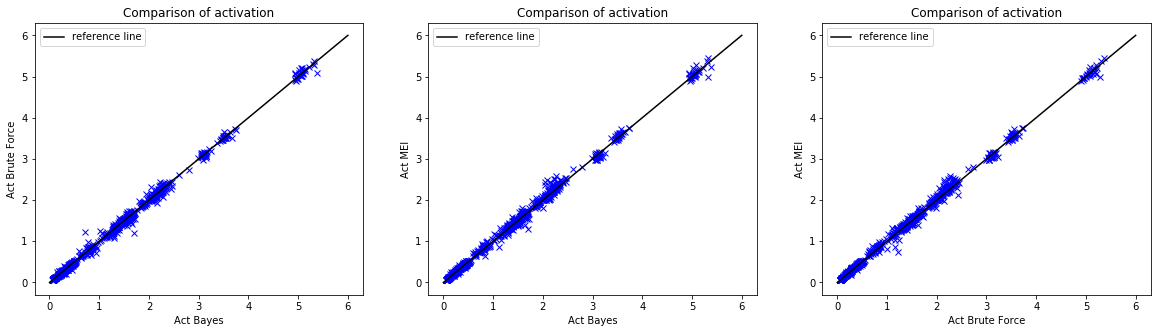

In [55]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
ax[0].plot(act_Bay, act_BF, 'x', color='b')
ax[0].plot([0,6], [0,6], color='k', label='reference line')
ax[0].set_title("Comparison of activation")
ax[0].set_xlabel("Act Bayes")
ax[0].set_ylabel("Act Brute Force")
ax[0].legend()

ax[1].plot(act_Bay, act_mei, 'x', color='b')
ax[1].plot([0,6], [0,6], color='k', label='reference line')
ax[1].set_title("Comparison of activation")
ax[1].set_xlabel("Act Bayes")
ax[1].set_ylabel("Act MEI")
ax[1].legend()

ax[2].plot(act_BF, act_mei, 'x', color='b')
ax[2].plot([0,6], [0,6], color='k', label='reference line')
ax[2].set_title("Comparison of activation")
ax[2].set_xlabel("Act Brute Force")
ax[2].set_ylabel("Act MEI")
ax[2].legend()

# normalize with MEI activation!